### Initial setup

In [1]:
# common
import pandas as pd
import numpy as np

api_key = ''
with open('api_key.txt', mode='r') as f:
    api_key = f.read()

#### Sample test

In [2]:
# # import data

# ts = TimeSeries(key=api_key, output_format='pandas')
# data, metadata = ts.get_daily(symbol='AAPL', outputsize='compact')

# # view some of the data
# print(data.head())

# # plotting the data into candlestick chart
# data.columns = ['open', 'high', 'low', 'close', 'volume']
# data.index = pd.to_datetime(data.index)
# mpf.plot(data.tail(60), 
#          type='candle', 
#          style='charles',
#          volume=True,
#          title='Apple Daily',
#          ylabel='Price ($)',
#          xlabel='Volume')


## Data module

In [3]:
# for data
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators

LOCAL_TZ = 'Asia/Ho_Chi_Minh'
# TODO: apply recommended number of period
PERIOD_NUM = 50 # default number of period for calculating

In [4]:
class Stock:
    """Class for retrieving stock data"""
    def __init__(self, symbol: str):
        # obtaining live data from API for now, maybe replaced with database query later
        self.ts = TimeSeries(key=api_key, output_format='pandas')
        self.data, self.metadata = self.ts.get_daily(symbol=symbol, outputsize='full')
        self.data.sort_index(inplace=True)
        self.data.columns = ['open', 'high', 'low', 'close', 'volume']
        

    @property
    def datainfo(self):
        return self.metadata
    
    
    def get_stock_data(self, startdate, enddate):
        return self.data.loc[startdate:enddate]

In [5]:
class Indicators:
    """class for retrieving indicators data"""
    def __init__(self, symbol: str) -> None:
        self.ti = TechIndicators(key=api_key, output_format='pandas')
        self.symbol = symbol
                
        
    def moving_avg(self, startdate, enddate, time_period=PERIOD_NUM, series_type='close'):
        self.sma, temp = self.ti.get_sma(self.symbol, 'daily', time_period, series_type)
        self.sma.index = pd.to_datetime(self.sma.index)
        self.sma.sort_index(inplace=True)
        return self.sma.loc[startdate:enddate]
    
    
    def multi_moving_avg(self, startdate, enddate, time_periods: list, series_type='close'):
        self.multi_sma = [(period, self.ti.get_sma(self.symbol, 'daily', period, series_type)[0]) for period in time_periods]
        for period, sma in self.multi_sma:
            sma.index = pd.to_datetime(sma.index)
            sma.sort_index(inplace=True)
        return [(period, sma.loc[startdate:enddate]) for period, sma in self.multi_sma]
    
    
    def expo_moving_avg(self, startdate, enddate, time_period=PERIOD_NUM, series_type='close'):
        self.ema, temp = self.ti.get_ema(self.symbol, 'daily', time_period, series_type)
        self.ema.index = pd.to_datetime(self.ema.index)
        self.ema.sort_index(inplace=True)
        
        return self.sma.loc[startdate:enddate]    
    
    
    # def moving_avg_conv_div(self, startdate, enddate, 
    #                         fast_period: int = 12, slow_period: int = 26, signal_period: int = 9,
    #                         series_type='close'):
    #     if not hasattr(self, 'macd'):
    #         self.macd, temp = self.ti.get_macd(self.symbol, 'daily', series_type, fast_period, slow_period, signal_period)
    #         self.macd.index = pd.to_datetime(self.macd.index)
    #         self.macd.sort_index(inplace=True)
            
    #     return self.macd.loc[startdate:enddate]
    
    
    def relative_strength(self, startdate, enddate, time_period=PERIOD_NUM, series_type='close'):
        self.rsi, temp = self.ti.get_rsi(self.symbol, 'daily', time_period, series_type)
        self.rsi.index = pd.to_datetime(self.rsi.index)
        self.rsi.sort_index(inplace=True)
        return self.rsi.loc[startdate:enddate]
    
    
    def bollinger_bands(self, startdate, enddate, time_period=PERIOD_NUM, series_type='close', nbdev=(2,2), ma_type='simple'):
        ma_dict = {'simple': 1, 'expo': 2}
        self.bbands, temp = self.ti.get_bbands(self.symbol, 'daily', time_period, series_type, nbdev[0], nbdev[1], ma_dict[ma_type])
        self.bbands.index = pd.to_datetime(self.bbands.index)
        self.bbands.sort_index(inplace=True)
        return self.bbands.loc[startdate:enddate] 

#### Test run: obtain data

In [6]:
stock = Stock('AAPL')
indicators = Indicators('AAPL')

In [ ]:
startdate = '2023-01-01'
enddate = '2023-12-31'

stock_data = stock.get_stock_data(startdate, enddate)
stock_data['sma_short'] = indicators.moving_avg(startdate, enddate, 50)
stock_data['sma_long'] = indicators.moving_avg(startdate, enddate, 200)
stock_data['ema'] = indicators.expo_moving_avg(startdate, enddate)
stock_data['rsi'] = indicators.relative_strength(startdate, enddate)
# multi_sma = indicators.multi_moving_avg(startdate, enddate, [2*i for i in range(3,10)])
# stock_data['macd'] = indicators.moving_avg_conv_div(startdate, enddate)  # TODO: calculate macd locally
bbands = indicators.bollinger_bands(startdate, enddate)
stock_data['lower_bband'] = bbands['Real Lower Band']
stock_data['middle_bband'] = bbands['Real Middle Band']
stock_data['upper_bband'] = bbands['Real Upper Band']

C:\Users\acer\AppData\Local\Temp\ipykernel_1104\320551530.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['sma_short'] = indicators.moving_avg(startdate, enddate, 50)
C:\Users\acer\AppData\Local\Temp\ipykernel_1104\320551530.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['sma_long'] = indicators.moving_avg(startdate, enddate, 200)
C:\Users\acer\AppData\Local\Temp\ipykernel_1104\320551530.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [20]:
print(f"Data size: {stock_data.shape[0]}")
print(stock_data.head())
print(stock_data.tail())
print(stock_data.isna().sum())  # Check for NaN values

Data size: 250
               open      high     low   close       volume  sma_short  \
date                                                                    
2023-01-03  130.280  130.9000  124.17  125.07  112117471.0   141.1798   
2023-01-04  126.890  128.6557  125.08  126.36   89113633.0   140.7708   
2023-01-05  127.130  127.7700  124.76  125.02   80962708.0   140.2921   
2023-01-06  126.010  130.2900  124.89  129.62   87754715.0   139.8475   
2023-01-09  130.465  133.4100  129.89  130.15   70790813.0   139.4724   

            sma_long       ema      rsi  lower_bband  middle_bband  \
date                                                                 
2023-01-03  149.5171  149.5171  42.2715     123.9242      139.1615   
2023-01-04  149.3346  149.3346  42.8436     122.7704      138.6081   
2023-01-05  149.1386  149.1386  42.3982     121.6116      138.0243   
2023-01-06  148.9484  148.9484  44.4221     121.1560      137.6420   
2023-01-09  148.7540  148.7540  44.6507     120.6748 

## Visualization module

In [9]:
# for plotting graph
import matplotlib.pyplot as plt
import mplfinance as mpf

In [10]:
class Patterns:
    def __init__(self) -> None:
        pass


    def is_hammer(self, row):
        body = abs(row['close'] - row['open'])
        lower_shadow = row['open'] - row['low'] if row['close'] > row['open'] else row['close'] - row['low']
        upper_shadow = row['high'] - row['close'] if row['close'] > row['open'] else row['high'] - row['open']
        return lower_shadow > 2 * body and upper_shadow < body


    def is_hanging_man(self, row):
        body = abs(row['close'] - row['open'])
        lower_shadow = row['open'] - row['low'] if row['close'] > row['open'] else row['close'] - row['low']
        upper_shadow = row['high'] - row['close'] if row['close'] > row['open'] else row['high'] - row['open']
        return lower_shadow > 2 * body and upper_shadow < body and row['close'] < row['open']
    
    
    def is_bullish_engulfing(self, prev_row, curr_row):
        return (curr_row['close'] > curr_row['open'] and 
                prev_row['close'] < prev_row['open'] and 
                curr_row['close'] > prev_row['open'] and 
                curr_row['open'] < prev_row['close'])
        

    def is_bearish_engulfing(self, prev_row, curr_row):
        return (curr_row['close'] < curr_row['open'] and 
                prev_row['close'] > prev_row['open'] and 
                curr_row['close'] < prev_row['open'] and 
                curr_row['open'] > prev_row['close'])


    def is_doji_or_spinning_top(self, row):
        body = abs(row['close'] - row['open'])
        upper_shadow = row['high'] - max(row['open'], row['close'])
        lower_shadow = min(row['open'], row['close']) - row['low']
        return body < (upper_shadow + lower_shadow) * 0.1  # Doji or Spinning Top has very small body


    def is_abandoned_baby_top(self, prev_row, curr_row, next_row):
        # Abandoned Baby Top: a gap up and then a down move, all candlesticks have no overlap
        return (curr_row['open'] > prev_row['close'] and curr_row['close'] > prev_row['close'] and
                next_row['open'] < curr_row['close'] and next_row['close'] < curr_row['close'])


    def is_abandoned_baby_bottom(self, prev_row, curr_row, next_row):
        # Abandoned Baby Bottom: a gap down and then an up move, all candlesticks have no overlap
        return (curr_row['open'] < prev_row['close'] and curr_row['close'] < prev_row['close'] and
                next_row['open'] > curr_row['close'] and next_row['close'] > curr_row['close'])

C:\Users\acer\AppData\Local\Temp\ipykernel_1104\3013219119.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Pattern'] = None
C:\Users\acer\AppData\Local\Temp\ipykernel_1104\3013219119.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Pattern_marker'] = None
C:\Users\acer\AppData\Local\Temp\ipykernel_1104\3013219119.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

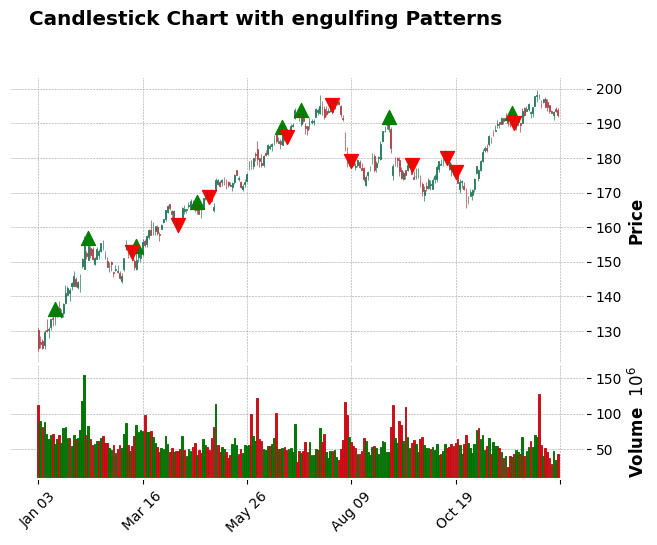

In [19]:
class Graph:
    def __init__(self) -> None:
        self.COLOR_SMA = 'blue'
        
        
    def plot_candlestick(self, stock_data):
        mpf.plot(
            stock_data,
            type='candle',
            volume=True,
            style='charles',
            title='Stock Price with indicators',
            ylabel='Price',
            ylabel_lower='Volume'
        )  
        plt.legend()
        plt.show()
        
    
    def plot_candlestick_with_single_ma(self, stock_data, ma_data, num_period, ma_type='simple'):
        add_plot = [
            mpf.make_addplot(ma_data, color=self.COLOR_SMA, label=f'{num_period}-period {ma_type} moving average')
        ]
        mpf.plot(
            data=stock_data,
            type='candle',
            style='charles',
            addplot=add_plot,
            volume=True,
            title='Stock Price with Simple Moving Average',
            ylabel='Price',
            ylabel_lower='Volume'
        )
    
    
    def plot_candlestick_with_multiple_ma(self, stock_data, multi_ma_data):
        add_plot = [
            mpf.make_addplot(sma, color=self.COLOR_SMA, width=0.5) for period, sma in multi_ma_data
        ]
        mpf.plot(
            data=stock_data,
            type='candle',
            style='charles',
            addplot=add_plot,
            volume=True,
            title='Stock price with multiple Simple Moving Average',
            ylabel='Price',
            ylabel_lower='Volume'
        )
        
        
    def plot_candlestick_with_bbands(self, stock_data, bbands):
        upper_bband = mpf.make_addplot(bbands['Real Upper Band'], color='red', width=1.0, linestyle='--', secondary_y=False)
        middle_bband = mpf.make_addplot(bbands['Real Middle Band'], color='green', width=1.0, linestyle='-', secondary_y=False)
        lower_bband = mpf.make_addplot(bbands['Real Lower Band'], color='red', width=1.0, linestyle='--', secondary_y=False)
        mpf.plot(
            stock_data,
            type='candle',
            style='charles',
            addplot=[upper_bband, middle_bband, lower_bband],
            volume=True,
            title='Stock Price with Bollinger Bands',
            ylabel='Price',
            ylabel_lower='Volume'
        )
    
    
    def plot_candlestick_with_pattern(self, stock_data, pattern_name=None):
        patt = Patterns()
        stock_data['Pattern'] = None
        stock_data['Pattern_marker'] = None

        # Define pattern detection logic based on the pattern_name parameter
        for i in range(1, len(stock_data) - 1):
            if pattern_name == "doji/spinning":
                if patt.is_doji_or_spinning_top(stock_data.iloc[i]):
                    stock_data.at[stock_data.index[i], 'Pattern'] = 'Doji/Spinning Top'
                    stock_data.at[stock_data.index[i], 'Pattern_marker'] = 'green'  # Doji/Spinning Top is indecision, mark with green
            elif pattern_name == "engulfing":
                if patt.is_bullish_engulfing(stock_data.iloc[i-1], stock_data.iloc[i]):
                    stock_data.at[stock_data.index[i], 'Pattern'] = 'Bullish Engulfing'
                    stock_data.at[stock_data.index[i], 'Pattern_marker'] = 'green'  
                elif patt.is_bearish_engulfing(stock_data.iloc[i-1], stock_data.iloc[i]):
                    stock_data.at[stock_data.index[i], 'Pattern'] = 'Bearish Engulfing'
                    stock_data.at[stock_data.index[i], 'Pattern_marker'] = 'red'  
            elif pattern_name == "hammer/hanging":
                if patt.is_hammer(stock_data.iloc[i]):
                    stock_data.at[stock_data.index[i], 'Pattern'] = 'Hammer'
                    stock_data.at[stock_data.index[i], 'Pattern_marker'] = 'green'  # Hammer is bullish
                elif patt.is_hanging_man(stock_data.iloc[i]):
                    stock_data.at[stock_data.index[i], 'Pattern'] = 'Hanging Man'
                    stock_data.at[stock_data.index[i], 'Pattern_marker'] = 'red'  # Hanging Man is bearish
            elif pattern_name == "abandoned_baby":
                if patt.is_abandoned_baby_top(stock_data.iloc[i-1], stock_data.iloc[i], stock_data.iloc[i+1]):
                    stock_data.at[stock_data.index[i], 'Pattern'] = 'Abandoned Baby Top'
                    stock_data.at[stock_data.index[i], 'Pattern_marker'] = 'red'  # Abandoned Baby Top is bearish
                elif patt.is_abandoned_baby_bottom(stock_data.iloc[i-1], stock_data.iloc[i], stock_data.iloc[i+1]):
                    stock_data.at[stock_data.index[i], 'Pattern'] = 'Abandoned Baby Bottom'
                    stock_data.at[stock_data.index[i], 'Pattern_marker'] = 'green'  # Abandoned Baby Bottom is bullish

        # Replace None with NaN for proper handling by mpf
        stock_data['Pattern_marker'] = stock_data['Pattern_marker'].replace({None: float('nan')})

        # Check for green markers
        if stock_data['Pattern_marker'].eq('green').any():
            green_markers = mpf.make_addplot(
                np.where(stock_data['Pattern_marker'] == 'green', stock_data['high'] * 1.01, np.nan),
                type='scatter', markersize=100, marker='^', color='green'
            )
        else:
            green_markers = None

        # Check for red markers
        if stock_data['Pattern_marker'].eq('red').any():
            red_markers = mpf.make_addplot(
                np.where(stock_data['Pattern_marker'] == 'red', stock_data['high'] * 0.99, np.nan),
                type='scatter', markersize=100, marker='v', color='red'
            )
        else:
            red_markers = None

        # Prepare addplots list based on available markers
        addplots = []
        if green_markers is not None:
            addplots.append(green_markers)
        if red_markers is not None:
            addplots.append(red_markers)

        # Plot the candlestick chart with available markers
        mpf.plot(
            stock_data,
            type='candle',
            style='charles',
            title=f'Candlestick Chart with {pattern_name} Patterns',
            ylabel='Price',
            addplot=addplots,
            volume=True
        )
        
        
graph = Graph()
graph.plot_candlestick_with_pattern(stock_data, pattern_name='engulfing')
# graph.plot_candlestick_with_sma(stock_data, stock_data['sma_short'], 10)
# graph.plot_candlestick_with_single_ma(stock_data, stock_data['sma_long'], 25)
# graph.plot_candlestick_with_multiple_sma(stock_data, multi_sma)
# graph.plot_candlestick_with_bbands(stock_data, bbands)

## Testing module

In [20]:
import backtrader as bt

In [21]:
# prepare data format
class PandasData(bt.feeds.PandasData):
    """
    Custom PandasData class to integrate additional columns like indicators.
    """
    lines = ('sma_short', 'sma_long', 'ema', 'rsi', 'lower_bband', 'middle_bband', 'upper_bband')
    params = (
        ('sma_short', 5),
        ('sma_long', 6),   
        ('ema', 7),
        ('rsi', 8),        
        ('lower_bband', 9),
        ('middle_bband', 10),
        ('upper_bband', 11)
    )

In [22]:
# class CustomIndicatorStrategy(bt.Strategy):
#     params = dict(
#         sma_short_period=10,
#         sma_long_period=25,
#         rsi_period=50,
#     )

#     def __init__(self):
#         # Use precomputed lines from the custom PandasData feed
#         print(f"Data length: {len(self.datas[0])}")
#         self.sma_short = self.datas[0].sma_short
#         self.sma_long = self.datas[0].sma_long
#         self.rsi = self.datas[0].rsi

#     def next(self):
#         print(f"Date: {self.datas[0].datetime.date(0)}")
#         print(f"SMA Short: {self.sma_short[0]}, SMA Long: {self.sma_long[0]}, RSI: {self.rsi[0]}")

#         # Example strategy: SMA crossover + RSI confirmation
#         if self.sma_short[0] > self.sma_long[0]:
#             self.buy(size=5)  # Buy signal
#             print("Buy executed")
#         elif self.sma_short[0] < self.sma_long[0]:
#             self.sell(size=5)  # Sell signal
#             print("Sell executed")


#### Template for custom defined strategy

In [31]:
class CustomStrategy(bt.Strategy):
    params = (
        ('entry_condition', None),
        ('exit_condition', None),
        ('risk_control', None),
        ('size_pct', None),
        ('stop_loss_pct', None),
        ('take_profit_pct', None),
        ('param1', None),
        ('param2', None)
    )

    def __init__(self):
        print(f"Data length: {len(self.datas[0])}")
        self.sma_short = self.datas[0].sma_short
        self.sma_long = self.datas[0].sma_long
        self.rsi = self.datas[0].rsi
        self.lower_bband = self.datas[0].lower_bband
        self.middle_bband = self.datas[0].middle_bband
        self.upper_bband = self.datas[0].upper_bband
        # conditions parameters
        self.entry_condition = self.params.entry_condition
        self.exit_condition = self.params.exit_condition
        self.risk_control = self.params.risk_control
        
        # trade paramters
        self.size_pct = self.params.size_pct
        self.stop_loss_pct = self.params.stop_loss_pct
        self.take_profit_pct = self.params.take_profit_pct
        self.param1 = self.params.param1
        self.param2 = self.params.param2
        
        # Track trade parameters
        self.entry_price = None
        self.stop_loss = None
        self.take_profit = None


    def next(self):
        print(f"Date: {self.datas[0].datetime.date(0)}")
        # If in a position, check for exit condition
        if self.position:
            if self.exit_condition:
                exit_signal = self.exit_condition(self) 
                if exit_signal:
                    self.close()
                    print(f'Exit position at {self.datas[0].close[0]}')
                    return
            # risk control
            if self.risk_control:
                risk_exit = self.risk_control(self)  
                if risk_exit:
                    self.close()
                    print('Risk control activated, exit trade!')
                    return
        else:
            # Check for entry condition
            if self.entry_condition:
                entry_signal = self.entry_condition(self)
                if entry_signal:
                    size = entry_signal.get('size', None)
                    self.buy(size=size)
                    # Capture entry price for risk management
                    self.entry_price = self.data.close[0]
                    self.stop_loss = entry_signal.get('stop_loss', None)
                    self.take_profit = entry_signal.get('take_profit', None)
                    print(f'Entered position at {self.data.close[0]}')
                    
                    
class Condition:
    @staticmethod
    def sma_crossover_golden_cross(strategy: CustomStrategy):
        short_ma = strategy.sma_short
        long_ma = strategy.sma_long
        if short_ma[0] > long_ma[0] and short_ma[-1] <= long_ma[-1]:
            size = strategy.broker.get_cash() * strategy.size_pct / strategy.data.close[0]  # Risk-based size
            stop_loss = strategy.datas[0].close[0] * (1 - strategy.stop_loss_pct)
            take_profit = strategy.datas[0].close[0] * (1 + strategy.take_profit_pct)
            return {'size': size, 'stop_loss': stop_loss, 'take_profit': take_profit}
        return None

    
    @staticmethod
    def sma_crossover_death_cross(strategy: CustomStrategy):
        short_ma = strategy.sma_short
        long_ma = strategy.sma_long
        if short_ma[0] < long_ma[0] and short_ma[-1] >= long_ma[-1]:
            size = strategy.broker.get_cash() * strategy.size_pct / strategy.data.close[0]  # Risk-based size
            stop_loss = strategy.datas[0].close[0] * (1 + strategy.stop_loss_pct)
            take_profit = strategy.datas[0].close[0] * (1 - strategy.take_profit_pct)
            return {'size': size, 'stop_loss': stop_loss, 'take_profit': take_profit}
        return None    
    
    @staticmethod
    def ema_crossover_bullish(strategy: CustomStrategy):
        ema = strategy.datas[0].ema
        short_ma = strategy.sma_short
        if ema[0] > short_ma[0] and ema[-1] <= short_ma[-1]:
            size = strategy.broker.get_cash() * strategy.size_pct / strategy.data.close[0]
            stop_loss = strategy.datas[0].close[0] * (1 - strategy.stop_loss_pct)
            take_profit = strategy.datas[0].close[0] * (1 + strategy.take_profit_pct)
            return {'size': size, 'stop_loss': stop_loss, 'take_profit': take_profit}
        return None    
    
    @staticmethod
    def ema_crossover_bearish(strategy: CustomStrategy):
        ema = strategy.datas[0].ema
        short_ma = strategy.sma_short
        if ema[0] < short_ma[0] and ema[-1] >= short_ma[-1]:
            size = strategy.broker.get_cash() * strategy.size_pct / strategy.data.close[0]
            stop_loss = strategy.datas[0].close[0] * (1 + strategy.stop_loss_pct)
            take_profit = strategy.datas[0].close[0] * (1 - strategy.take_profit_pct)
            return {'size': size, 'stop_loss': stop_loss, 'take_profit': take_profit}
        return None    

    @staticmethod
    def relative_strength_over_sold(strategy: CustomStrategy):
        rsi = strategy.rsi 
        if rsi < strategy.param2:
            size = strategy.broker.get_cash() * strategy.size_pct / strategy.data.close[0]  # Risk-based size
            stop_loss = strategy.datas[0].close[0] * (1 - strategy.stop_loss_pct)
            take_profit = strategy.datas[0].close[0] * (1 + strategy.take_profit_pct)
            return {'size': size, 'stop_loss': stop_loss, 'take_profit': take_profit}
        return None 


    @staticmethod
    def relative_strength_over_bought(strategy: CustomStrategy):
        rsi = strategy.rsi
        if rsi[0] > strategy.param1:  
            size = strategy.broker.get_cash() * strategy.size_pct / strategy.data.close[0]
            stop_loss = strategy.datas[0].close[0] * (1 + strategy.stop_loss_pct)
            take_profit = strategy.datas[0].close[0] * (1 - strategy.take_profit_pct)
            return {'size': size, 'stop_loss': stop_loss, 'take_profit': take_profit}
        return None

    @staticmethod
    def bband_squeeze_bullish(strategy: CustomStrategy):
        lower_bband = strategy.lower_bband
        close_price = strategy.datas[0].close[0]

        if close_price <= lower_bband[0]:
            size = strategy.broker.get_cash() * strategy.size_pct / close_price
            stop_loss = close_price * (1 - strategy.stop_loss_pct)
            take_profit = close_price * (1 + strategy.take_profit_pct)
            return {'size': size, 'stop_loss': stop_loss, 'take_profit': take_profit}

        return None
    
    
    def bband_squeeze_bearish(strategy: CustomStrategy):
        upper_bband = strategy.upper_bband
        close_price = strategy.datas[0].close[0]

        if close_price >= upper_bband[0]:
            size = strategy.broker.get_cash() * strategy.size_pct / close_price
            stop_loss = close_price * (1 + strategy.stop_loss_pct)
            take_profit = close_price * (1 - strategy.take_profit_pct)
            return {'size': size, 'stop_loss': stop_loss, 'take_profit': take_profit}

        return None

class RiskManagement:
    @staticmethod
    def simple_stop_loss(strategy: CustomStrategy):
        return False
    
    
    @staticmethod
    def simple_take_profit(strategy: CustomStrategy):
        return False

#### run backtest

In [32]:
def run_backtest(stock_data):
    # Initialize Backtrader
    cerebro = bt.Cerebro()
    data_feed = PandasData(dataname=stock_data)
    cerebro.adddata(data_feed)
    cerebro.addstrategy(
        CustomStrategy, 
        entry_condition = Condition.relative_strength_over_sold,
        exit_condition = Condition.relative_strength_over_bought,
        risk_control = RiskManagement.simple_stop_loss,
        size_pct = 0.5,
        stop_loss_pct = 0.05,
        take_profit_pct = 0.1,
        param1 = 70,            # param for overbough rsi threshold
        param2 = 30             # param for oversold rsi threshold
    )

    # Set initial cash and commissions
    cerebro.broker.setcash(10000.0)
    cerebro.broker.setcommission(commission=0.001)

    # Print starting balance
    print(f"Starting Portfolio Value: ${cerebro.broker.getvalue():.2f}")

    # Run the backtest
    cerebro.run()
    print(f"Ending Portfolio Value: ${cerebro.broker.getvalue():.2f}")
    cerebro.plot()
# Run the backtest with the prepared data
run_backtest(stock_data)

Starting Portfolio Value: $10000.00
Data length: 0
Date: 2023-01-03
Date: 2023-01-04
Date: 2023-01-05
Date: 2023-01-06
Date: 2023-01-09
Date: 2023-01-10
Date: 2023-01-11
Date: 2023-01-12
Date: 2023-01-13
Date: 2023-01-17
Date: 2023-01-18
Date: 2023-01-19
Date: 2023-01-20
Date: 2023-01-23
Date: 2023-01-24
Date: 2023-01-25
Date: 2023-01-26
Date: 2023-01-27
Date: 2023-01-30
Date: 2023-01-31
Date: 2023-02-01
Date: 2023-02-02
Date: 2023-02-03
Date: 2023-02-06
Date: 2023-02-07
Date: 2023-02-08
Date: 2023-02-09
Date: 2023-02-10
Date: 2023-02-13
Date: 2023-02-14
Date: 2023-02-15
Date: 2023-02-16
Date: 2023-02-17
Date: 2023-02-21
Date: 2023-02-22
Date: 2023-02-23
Date: 2023-02-24
Date: 2023-02-27
Date: 2023-02-28
Date: 2023-03-01
Date: 2023-03-02
Date: 2023-03-03
Date: 2023-03-06
Date: 2023-03-07
Date: 2023-03-08
Date: 2023-03-09
Date: 2023-03-10
Date: 2023-03-13
Date: 2023-03-14
Date: 2023-03-15
Date: 2023-03-16
Date: 2023-03-17
Date: 2023-03-20
Date: 2023-03-21
Date: 2023-03-22
Date: 2023-03-

<IPython.core.display.Javascript object>